In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [42]:
# Load train and test data
train_data_path = "./data/train.csv"
test_data_path = "./data/test.csv"

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Data overview
print('Train data shape: {} \nTest data shape: {}'.format(train_data.shape, test_data.shape)) # looks good

# Features
features = [feature for feature in train_data.columns]
print('Features: {}'.format(features))

# Select numeric columns (exclude passenger ID)
numeric_cols = train_data.iloc[:, 1:].select_dtypes(include=['number']).columns

# Select categorical columns (exclude passenger ID)
categorical_cols = train_data.iloc[:, 1:].select_dtypes(include=['object', 'category']).columns

print('\nNumeric features: {} \nCategorical features: {}'.format(numeric_cols, categorical_cols))

Train data shape: (891, 12) 
Test data shape: (418, 11)
Features: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Numeric features: Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object') 
Categorical features: Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')


In [3]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [14]:
# Edit categorical and numerical columns based on data description
labels = train_data['Survived']
numeric_cols = numeric_cols[2:]
categorical_cols = categorical_cols.union(pd.Index(['Pclass']))

# Sanity check
print((len(numeric_cols) + len(categorical_cols)) == (len(features) - 2))

True


**Exploratory data analysis**

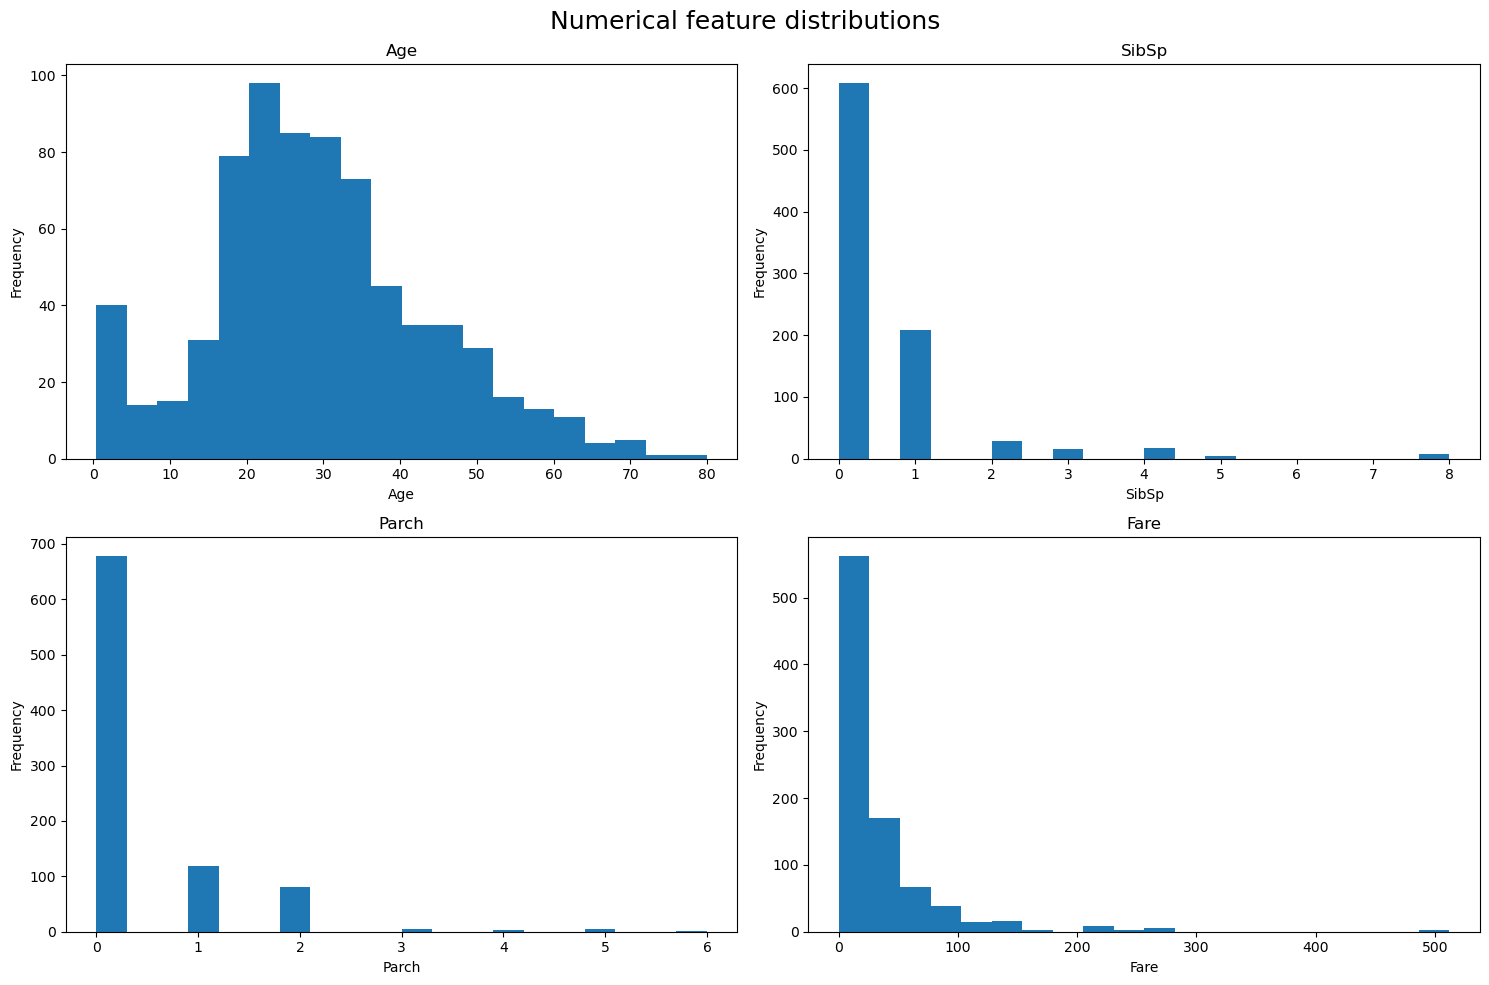

In [15]:
# Visualise numerical features
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Plot each histogram
for i, feature in enumerate(numeric_cols):
    train_data[feature].plot(kind='hist', ax=axes[i], title=feature, bins=20)
    axes[i].set_xlabel(feature)

# Remove any empty subplots if num_columns is not a perfect square
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Numerical feature distributions', fontsize = 18)
plt.tight_layout()
plt.show()

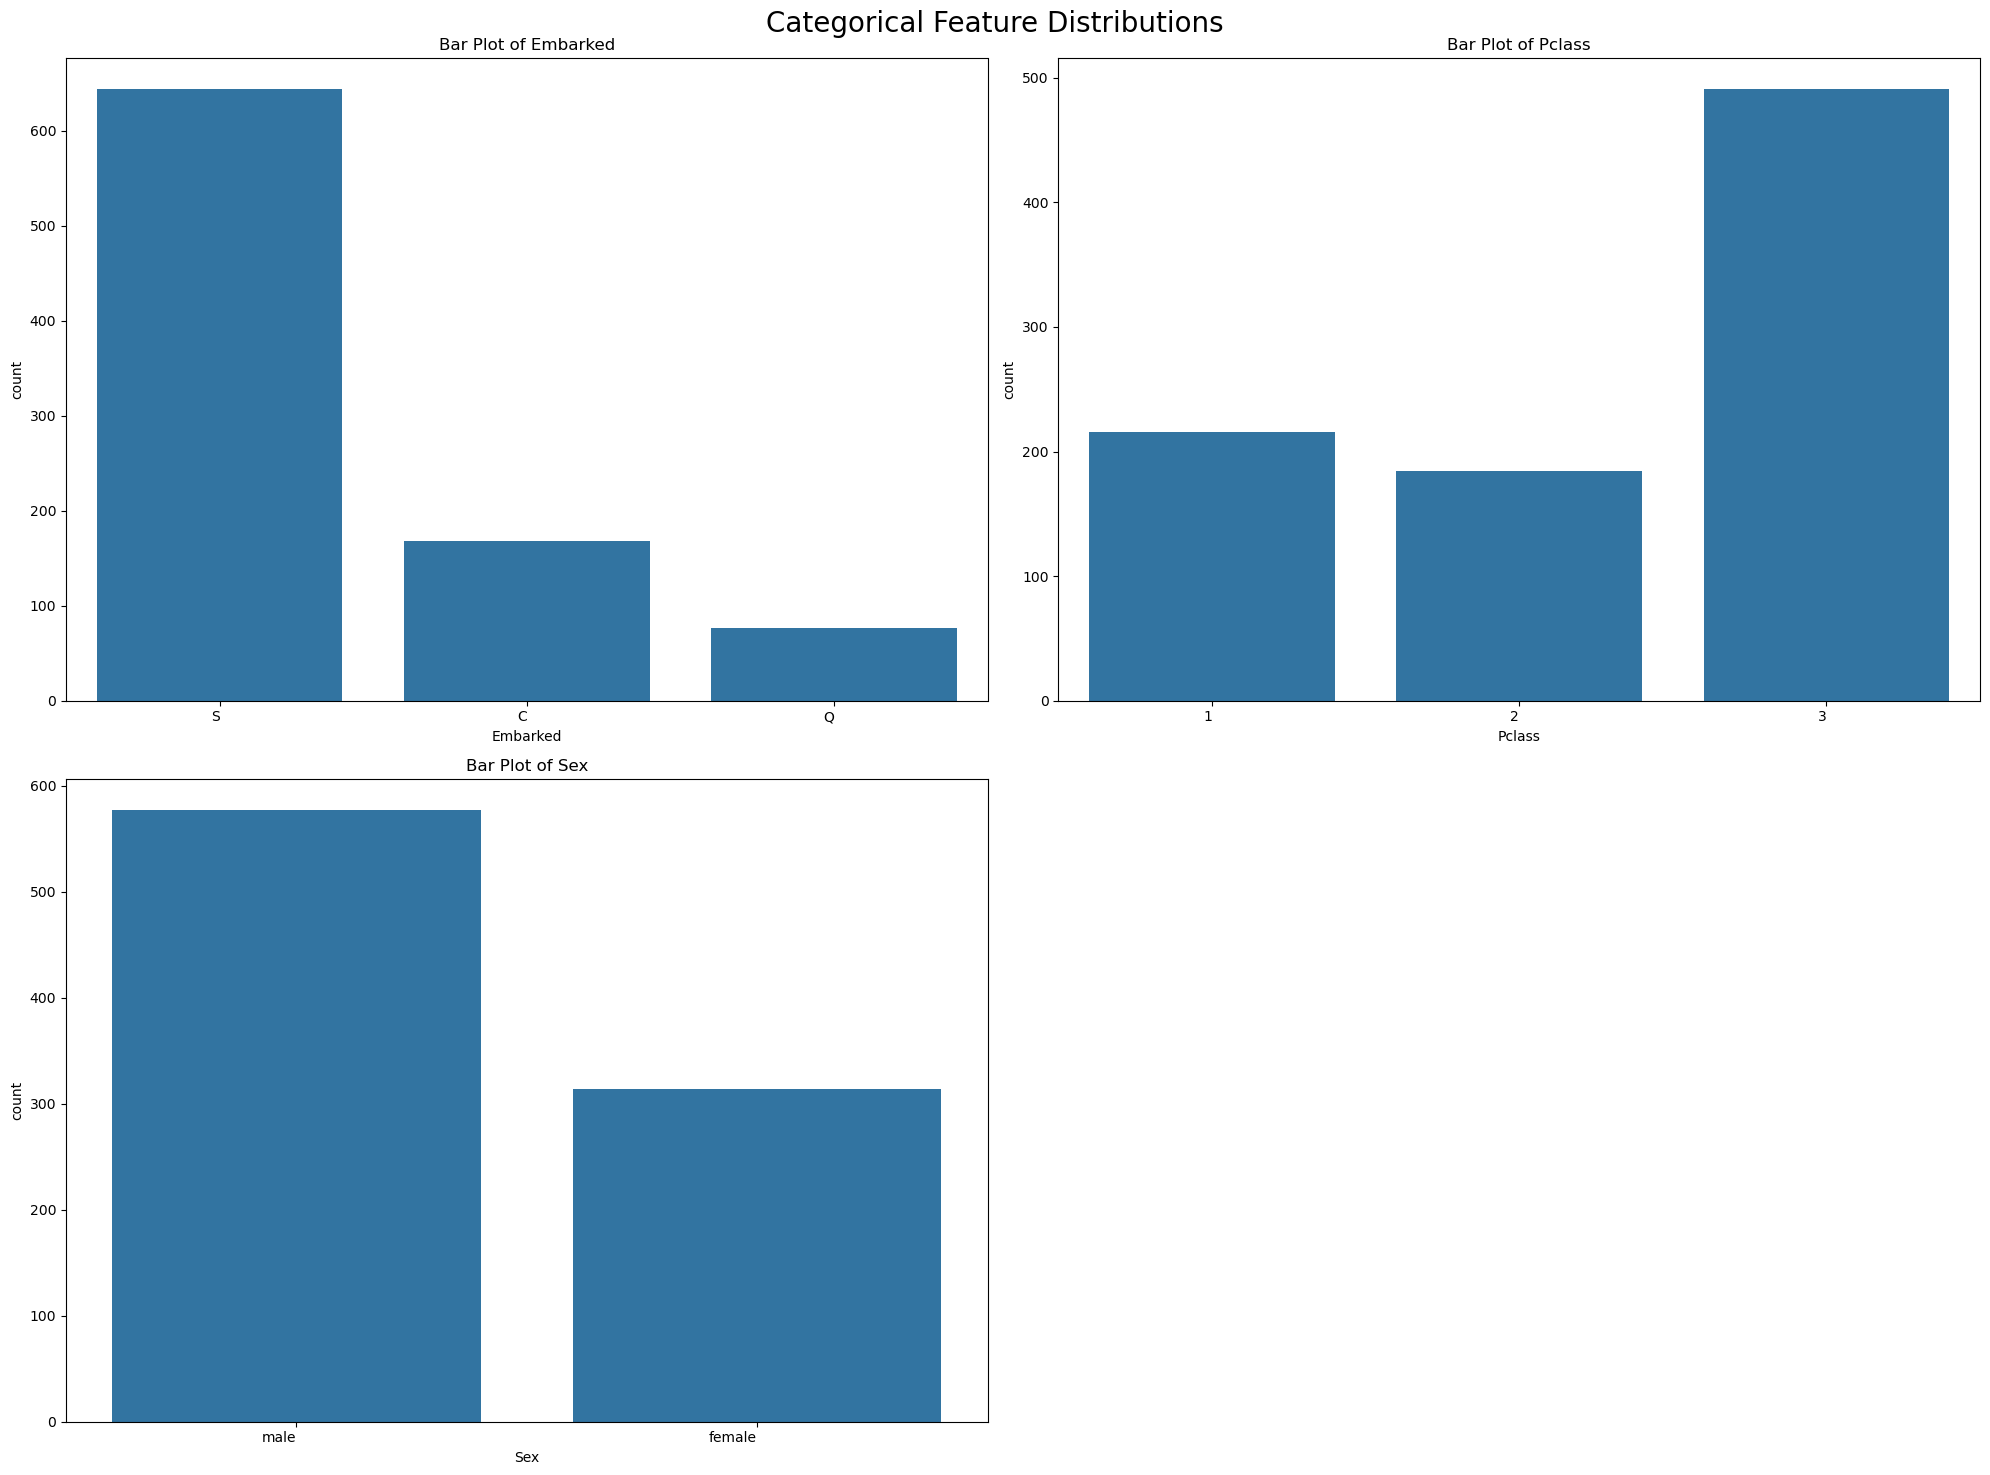

In [16]:
# Exclude 'Cabin', 'Name', and 'Ticket'
vis_cat_cols = ['Embarked', 'Pclass', 'Sex']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

# Plot each categorical feature in a subplot
for i, feature in enumerate(vis_cat_cols):
    sns.countplot(data=train_data, x=feature, ax=axes[i])
    axes[i].set_title(f'Bar Plot of {feature}')
    plt.setp(axes[i].get_xticklabels(), ha='right')

# Remove the empty subplot
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Categorical Feature Distributions', fontsize=20)
plt.tight_layout()
plt.show()

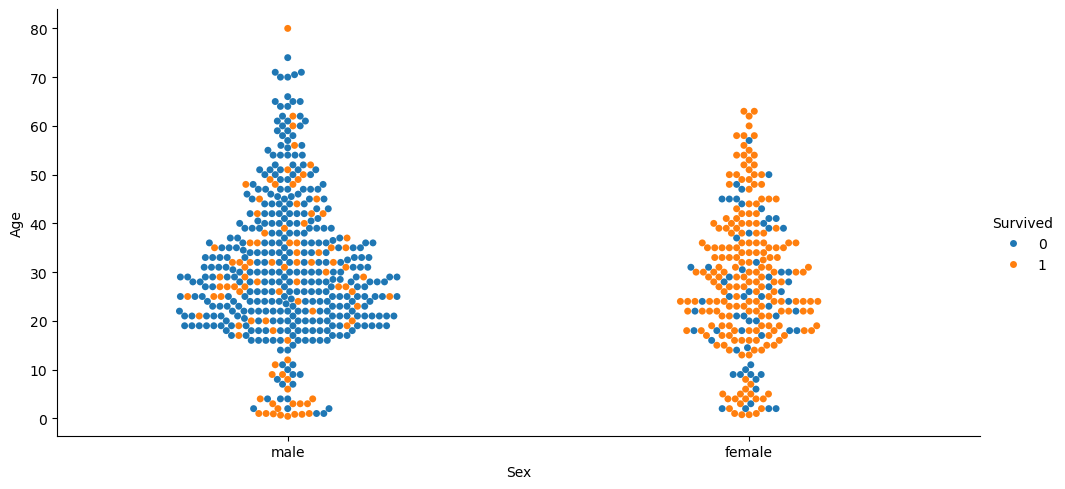

In [17]:
# Data visualisation with swarm plot
sns.catplot(data=train_data, x="Sex", y="Age", hue="Survived",height=5, aspect=2, kind="swarm")

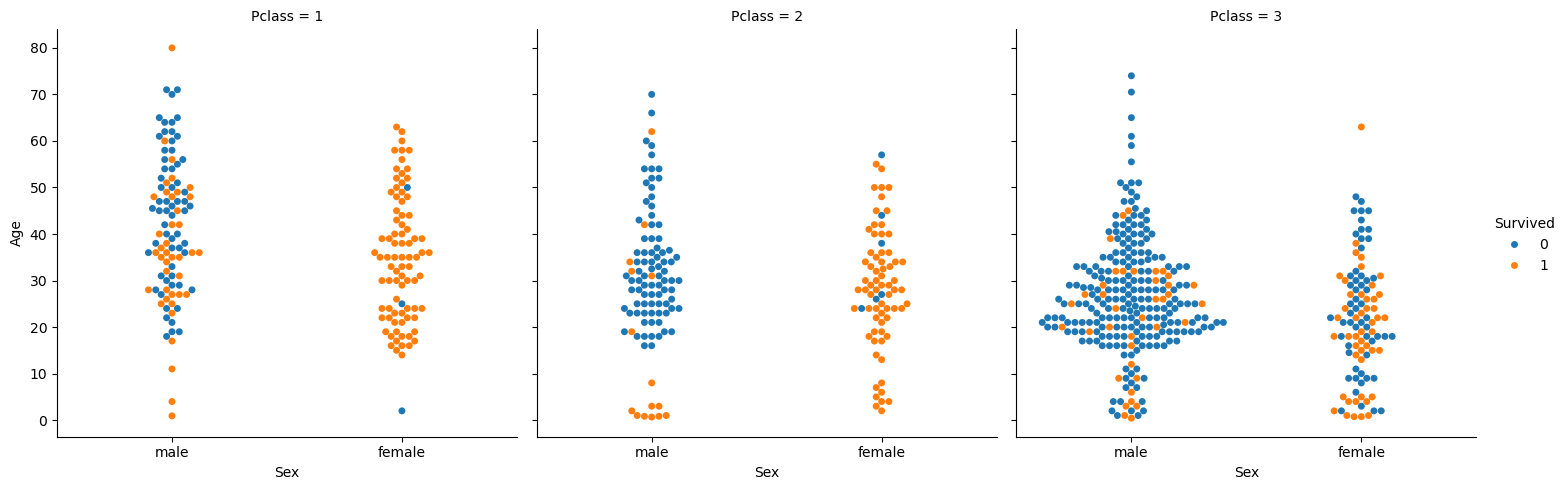

In [18]:
# Data visualisation with swarm plot

sns.catplot(data=train_data, col="Pclass", x = "Sex", y="Age", hue="Survived", height=5, aspect=1, kind="swarm")

# Women had a higher survival rate only in 1st and 2nd class
# Younger males had higher survival rate than older males 

In [19]:
# Missing values
print('Missing values by column in train data:')
print(train_data.isna().sum())

print('\nMissing values by column in test data:')
print(test_data.isna().sum())

Missing values by column in train data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values by column in test data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [20]:
# Missing values (2)
check = train_data.isnull().sum() / len(train_data)

# Identifying columns with more that 50 % of NaN
cols = list(check[check > 0.5].index) 

# Dropping the identifyed columns from the train set
train_data.drop(cols, axis = 1, inplace= True)

# Dropping the columns from test set
test_data.drop(cols, axis = 1, inplace= True) 

# Names of remaining columns with missing values in train and test set
columns_nan = [column for column in train_data.columns if train_data[column].isna().sum() != 0] 
columns_nan_test = [column for column in test_data.columns if test_data[column].isna().sum() != 0]

In [43]:
# Impute missing values - train
for column in columns_nan:

    # Check if data is categorical
    if column in categorical_cols: 

        # Take 1st mode
        mode = train_data[column].mode()[0]

        # Fill missing values using mode
        train_data.fillna({column: mode}, inplace= True)
        
    else:

        # Fill numerical columns with mean
        mean = train_data[column].mean()
        train_data.fillna({column: mean}, inplace = True)

# Impute missing values - test
for column in columns_nan_test:

    # Check if data column is categorical
    if column in categorical_cols: 

        # Take 1st mode
        mode = train_data[column].mode()[0]

        # Fill missing values using mode
        test_data.fillna({column: mode}, inplace= True)
    else:

        # Fill numerical columns with mean
        mean = train_data[column].mean()
        test_data.fillna({column: mean}, inplace = True)

In [22]:
# Mapping categorical features
# Mapping for the 'Sex' column
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})

# Mapping for the 'Embarked' column
train_data['Embarked'] = train_data['Embarked'].map({'S': 1, 'C': 2, 'Q': 3})

In [23]:
# Correlation matrix (> ordinal features)
correlation_matrix = train_data[["Age", "SibSp", "Parch", "Fare", "Survived"]].corr()
print(correlation_matrix)

               Age     SibSp     Parch      Fare  Survived
Age       1.000000 -0.232625 -0.179191  0.091566 -0.069809
SibSp    -0.232625  1.000000  0.414838  0.159651 -0.035322
Parch    -0.179191  0.414838  1.000000  0.216225  0.081629
Fare      0.091566  0.159651  0.216225  1.000000  0.257307
Survived -0.069809 -0.035322  0.081629  0.257307  1.000000


In [24]:
# Chi2 test for categorical features and target
chi2_list = []
for feature in ["Pclass", "Sex", "Embarked"]:
    cross_table = pd.crosstab(index = train_data[feature], columns = train_data["Survived"])
    Chi_Sq = chi2_contingency(cross_table)
    chi2_list.append(Chi_Sq[1])

chi2_table = pd.DataFrame(chi2_list)

print(chi2_table)
print('All values are < .05, which means that all features correlate significantly with target.')

              0
0  4.549252e-23
1  1.197357e-58
2  2.300863e-06
All values are < .05, which means that all features correlate significantly with target.


**Machine Learning**

In [25]:
#Dividing data to a validation set and test set
# Features (excluding the target variable)
X = train_data.iloc[:, 2:]

# Labels (target variable)
y = train_data.iloc[:, 1]

# Split the dataset into training (80%) and validation (20%) sets
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the sizes of the resulting datasets
print(f"Training set size: {train_x.shape[0]} samples")
print(f"Validation set size: {valid_x.shape[0]} samples")

Training set size: 712 samples
Validation set size: 179 samples


Feature engineering

In [26]:
# Combine 'SibSP' and 'Parch' into 'FamilySize'
train_x['FamilySize'] = train_x['SibSp'] + train_x['Parch']
valid_x['FamilySize'] = valid_x['SibSp'] + valid_x['Parch']

In [27]:
# Define feature set
feature_set = ['Pclass', 'Sex', 'Age', 'FamilySize', 'Fare', 'Embarked'] # Ticked excluded due to the unique identifiers; 
# Cabin excluded due to too many missing values

Classification

In [28]:
# Hyperparameter tuning
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, 
                       cv=5, verbose=2, n_jobs=-1)

# Fit the model
rf_grid.fit(train_x[feature_set], train_y)

# Best parameters
print(f"Best parameters found: {rf_grid.best_params_}")

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estim

/Users/zojaanzur/miniconda3/envs/general/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


In [29]:
# Predicting the test set and classification report
# Make predictions
pred_y = rf_grid.best_estimator_.predict(valid_x[feature_set])

# Calculate accuracy
val_acc = accuracy_score(valid_y, pred_y)

# Generate classification report
report = classification_report(valid_y, pred_y, target_names=['Not Survived', 'Survived'])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

Not Survived       0.82      0.91      0.86       105
    Survived       0.85      0.72      0.78        74

    accuracy                           0.83       179
   macro avg       0.84      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



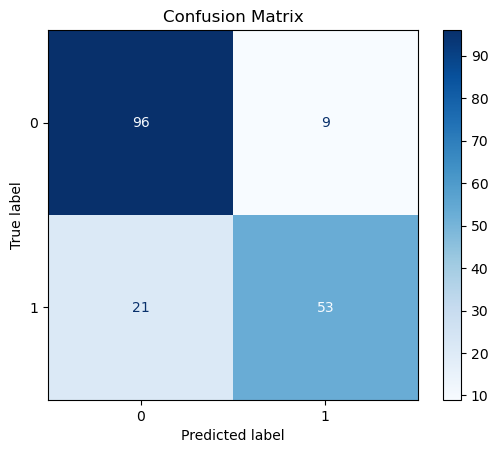

In [30]:
# Generate the confusion matrix
cm = confusion_matrix(valid_y, pred_y)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_grid.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Predicting survival on test data

In [44]:
# Impute missing values
test_data['Age'].fillna(test_data['Age'].mean(), inplace = True)

/var/folders/36/b4zwxjrn28v9lqp01_jxhqwc0000gn/T/ipykernel_12609/2987117969.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Age'].fillna(test_data['Age'].mean(), inplace = True)


In [45]:
# Mapping categorical features
# Mapping for the 'Sex' column
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})

# Mapping for the 'Embarked' column
test_data['Embarked'] = test_data['Embarked'].map({'S': 1, 'C': 2, 'Q': 3})

# Calculate family size
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch']

In [46]:
# Predict test the best model
pred_y = rf_grid.best_estimator_.predict(test_data[feature_set])

# Make output of predictions
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': pred_y})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
